In [2]:
import numpy as np
import os
import imageio
import cv2
import matplotlib.pyplot as plt
import glob
import skimage
import scipy
from skimage.filters import (threshold_otsu, threshold_niblack,
                             threshold_sauvola)

from skimage import morphology

# Load resources

In [3]:
cards = np.array([np.array(imageio.imread(filename)) for filename in sorted(glob.glob('./cards/*.jpg'))])

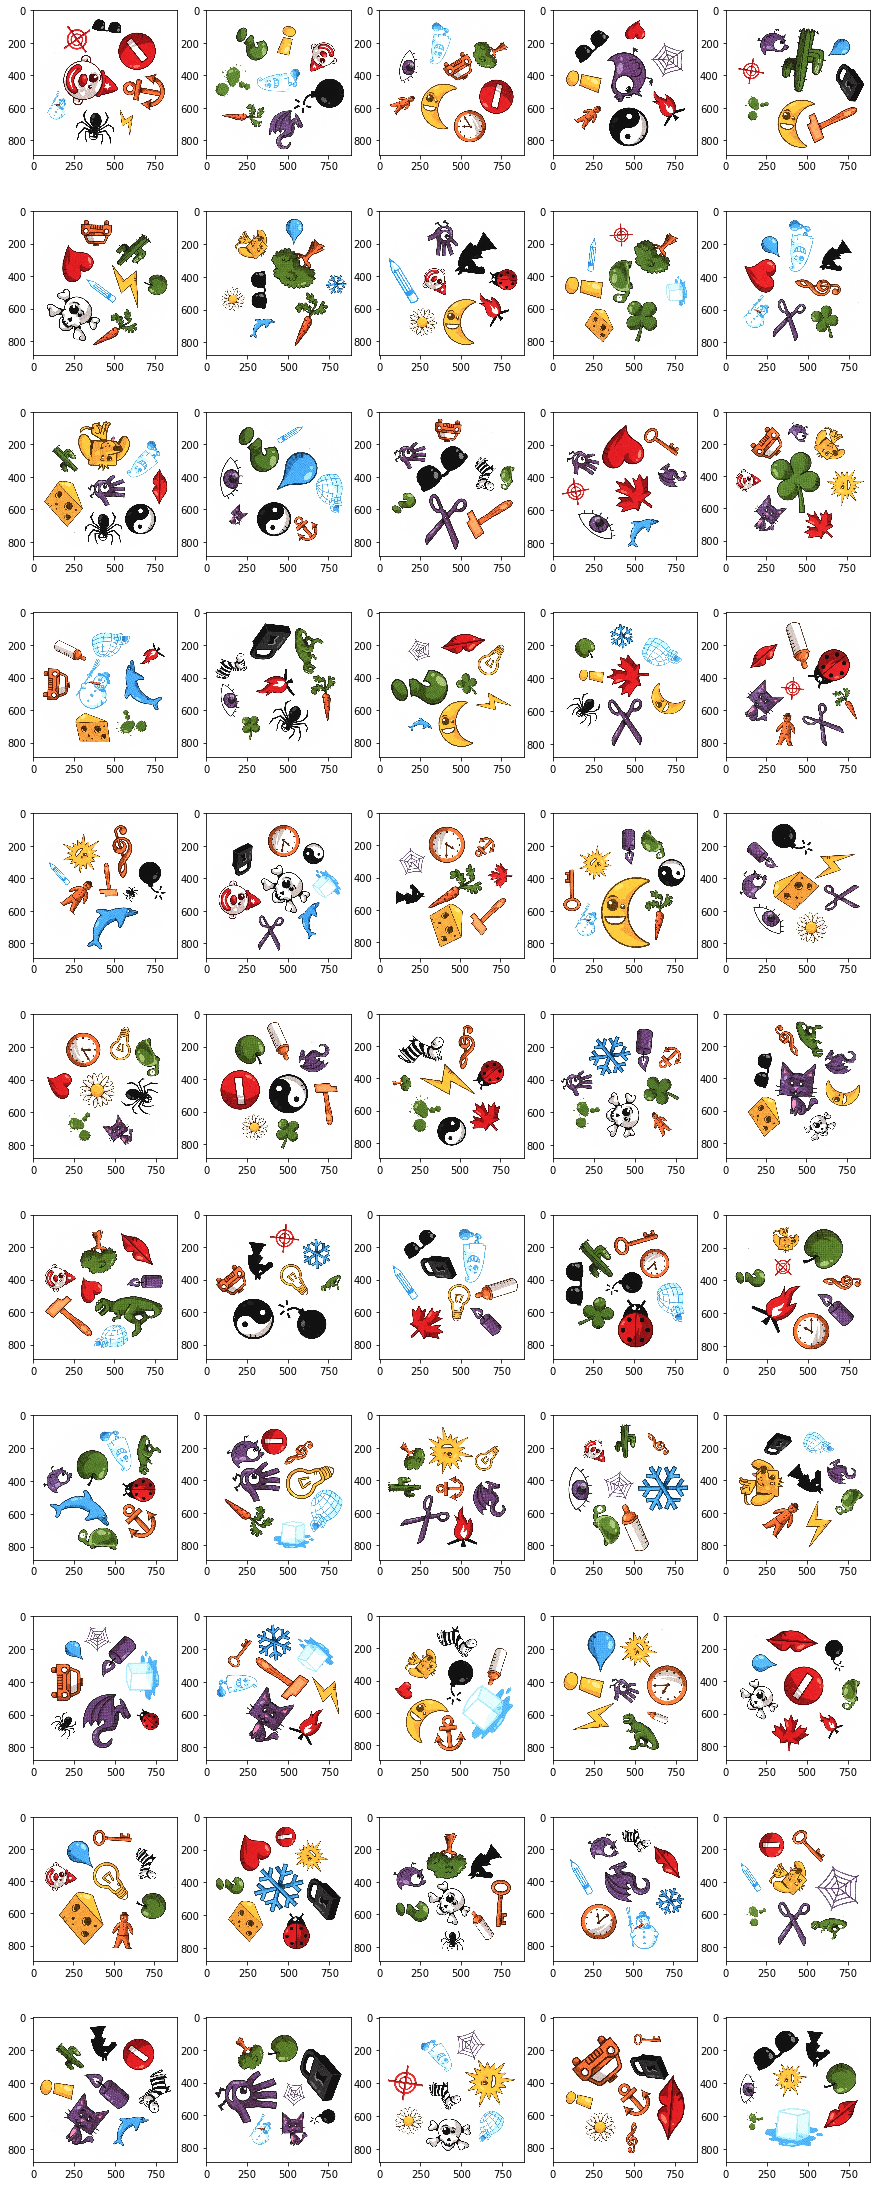

In [4]:
#print all images
fig=plt.figure(figsize=(15, 40))
for i, img in enumerate(cards):
    fig.add_subplot(11, 5, i+1)
    plt.imshow(img)
plt.show()

# Preprocessing

## Test on one card

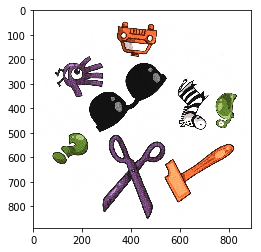

In [5]:
test_card = cards[12]
plt.imshow(test_card)

In [6]:
from skimage.filters import threshold_otsu

test_card = test_card.mean(2)

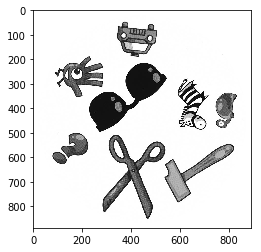

In [7]:
plt.imshow(test_card, cmap='gray')

In [8]:
test_card[test_card < 240] = 0

In [9]:
test_card = test_card == False

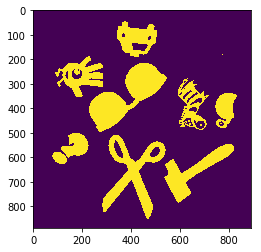

In [10]:
plt.imshow(test_card)

In [11]:
from skimage import morphology 
res = morphology.remove_small_holes(test_card, 40000)

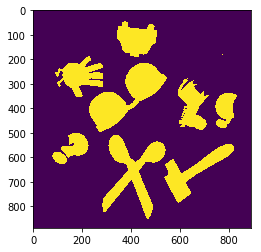

In [12]:
plt.imshow(res)

In [13]:
res = morphology.remove_small_objects(res, 90)

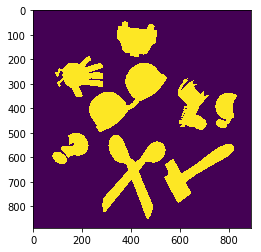

In [14]:
plt.imshow(res)

In [15]:
from skimage.measure import label

In [16]:
labels = label(res)

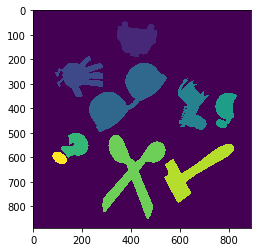

In [17]:
plt.imshow(labels)

In [18]:
#Count the number of symbols (should be 9, 8 symbols + the background)

print(len(np.unique(labels)))

10


In [19]:
# if more than 9
if (len(np.unique(labels)) > 9):
    selem = morphology.diamond(2)
    dilated = morphology.dilation(res, selem)
    labels = label(dilated)
    while len(np.unique(labels)) > 9:
        dilated = morphology.dilation(dilated, selem)
        labels = label(dilated)
        print(len(np.unique(labels)))

labels[res == 0] = 0


9


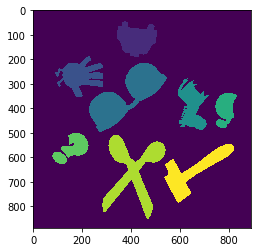

In [20]:
plt.imshow(labels)

## Test on all images

In [21]:
def get_symbols(img):
    img = img.mean(2)
    img[img < 240] = 0
    img = img == False
    res = morphology.remove_small_holes(img, 40000)
    res = morphology.remove_small_objects(res, 300)
    labels = label(res)
    if (len(np.unique(labels)) > 9):
        selem = morphology.diamond(2)
        dilated = morphology.dilation(res, selem)
        labels = label(dilated)
        while len(np.unique(labels)) > 9:
            dilated = morphology.dilation(dilated, selem)
            labels = label(dilated)
    labels[res == 0] = 0
    return labels
    

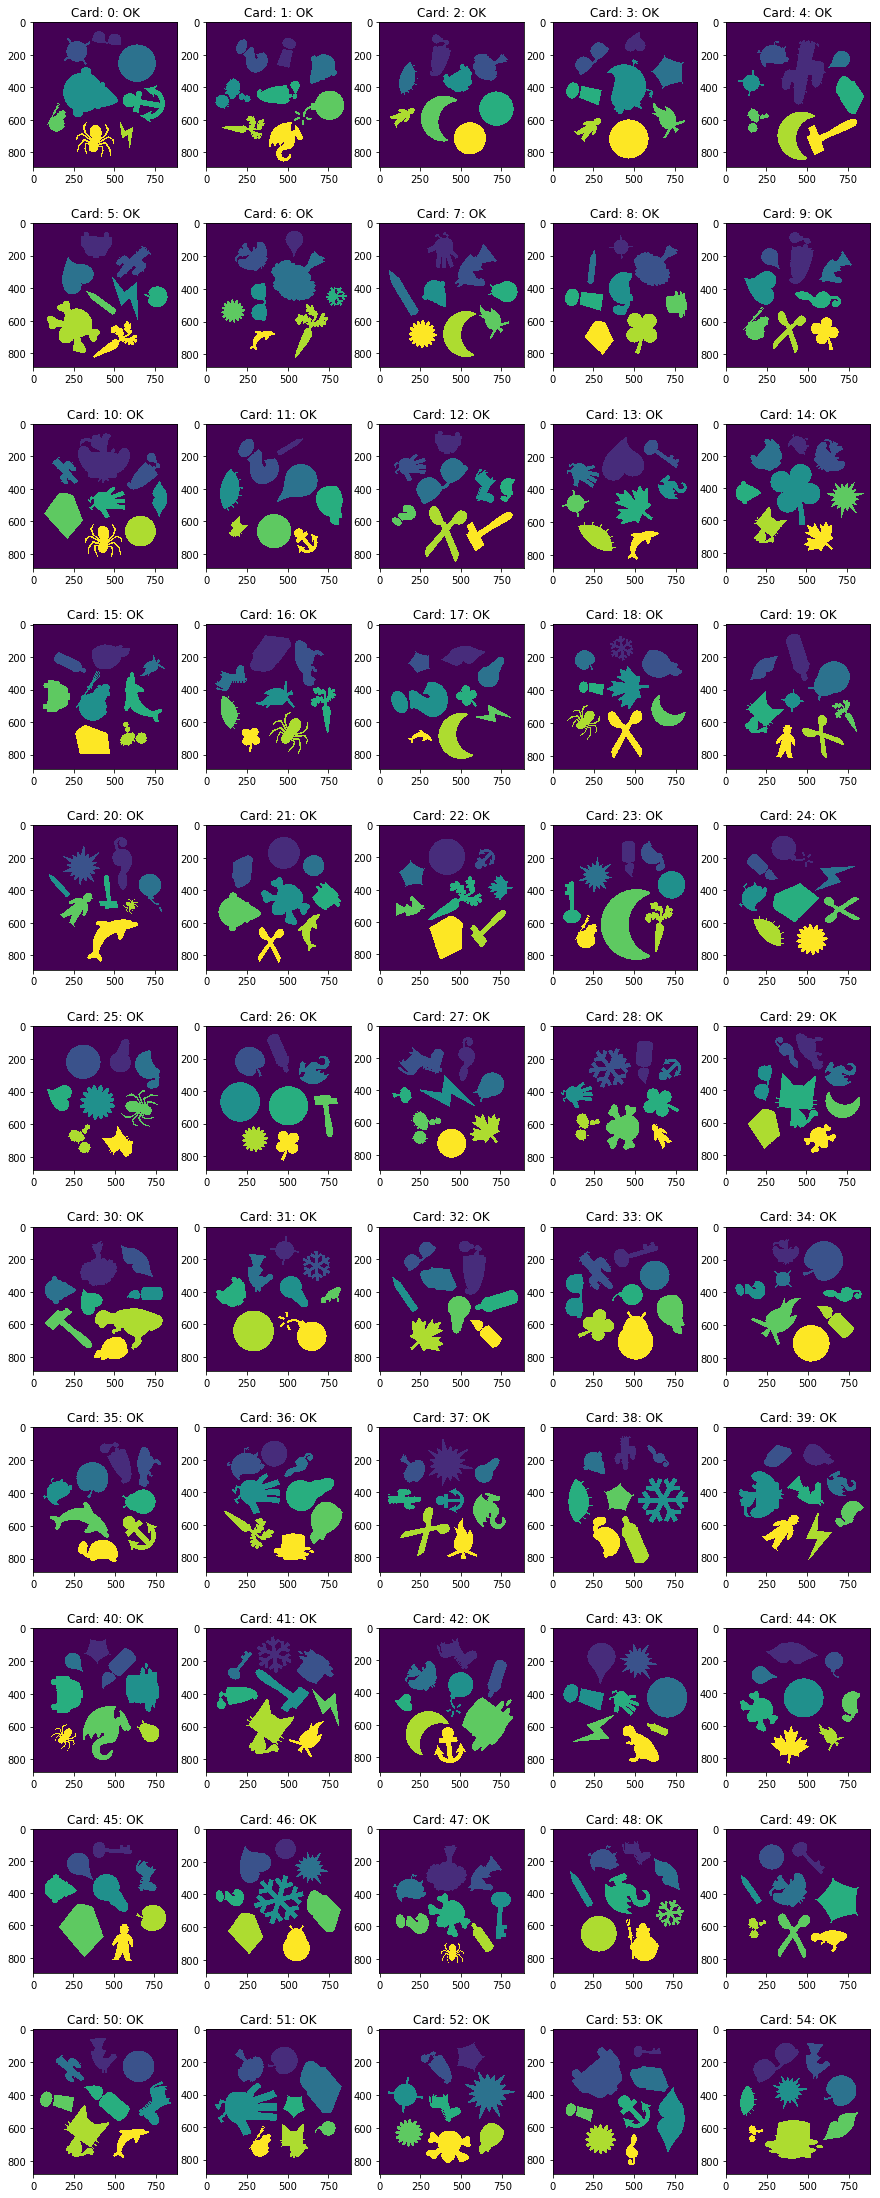

In [22]:
fig=plt.figure(figsize=(15, 40))
for i, card in enumerate(cards):
    symbols = get_symbols(card)
    fig.add_subplot(11, 5, i+1)
    title = "Card: " + str(i)
    if len(np.unique(symbols)) == 9:
        title += ": OK"
        plt.title(title)
    else:
        title += ": KO"
        title_obj = plt.title(title)
        plt.setp(title_obj, color='r')
    plt.imshow(symbols)
plt.show()


# Extract each symbol and compute sift on it 

## Extraction of one symbol

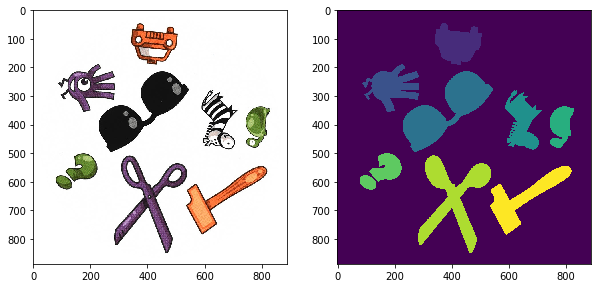

In [23]:
test_card = cards[12]
mask_syl = get_symbols(test_card)
fig=plt.figure(figsize=(10, 15))
fig.add_subplot(1, 2, 1)
plt.imshow(test_card)
fig.add_subplot(1, 2, 2)
plt.imshow(mask_syl)
plt.show()

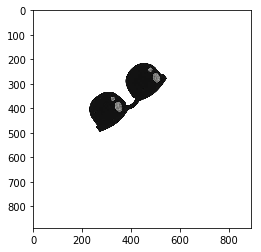

In [24]:
first_symbol = test_card.copy()
first_symbol[mask_syl != 3] = 255
plt.imshow(first_symbol)

## Center the symbol

In [25]:
# we search a boundary box

first_symbol[first_symbol == 255] = 0
col_sum = np.where(np.sum(first_symbol, axis = 0)>0)
row_sum = np.where(np.sum(first_symbol, axis = 1)>0)
y1, y2 = row_sum[0][0], row_sum[0][-1] 
x1, x2 = col_sum[0][0], col_sum[0][-1]
print(x1, y1)
print(x2, y2) 

229 214
545 496


In [26]:
# cropp image to get symbol
padding = 40
first_symbol = first_symbol[y1 - padding:y2 + padding, x1 - padding:x2 + padding]

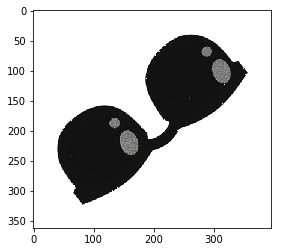

In [124]:
first_symbol[first_symbol == 0] = 255
plt.imshow(first_symbol)

In [29]:
def get_symbol(img, n_symbol):
    mask_syl = get_symbols(img)
    symbol = img.copy()
    symbol[mask_syl != n_symbol] = 255
    symbol[symbol == 255] = 0
    col_sum = np.where(np.sum(symbol, axis = 0)>0)
    row_sum = np.where(np.sum(symbol, axis = 1)>0)
    y1, y2 = row_sum[0][0], row_sum[0][-1] 
    x1, x2 = col_sum[0][0], col_sum[0][-1]
    padding = 40
    symbol = symbol[y1 - padding:y2 + padding, x1 - padding:x2 + padding]
    symbol[symbol ==0] = 255
    return symbol

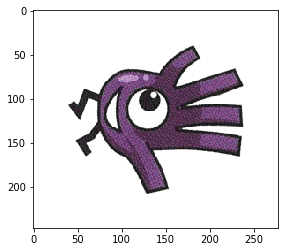

In [30]:
plt.imshow(get_symbol(cards[12], 2))

## Test matching between 2 symbols with RANSAC

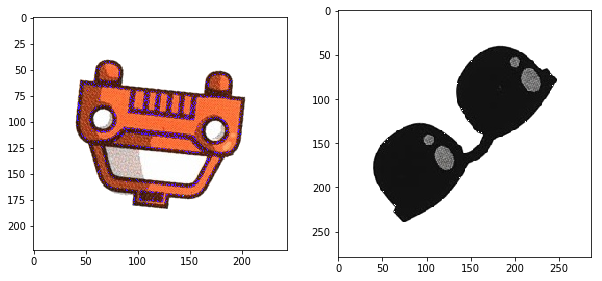

In [31]:
first_symbol = get_symbol(cards[12], 1)
second_symbol = get_symbol(cards[3], 2)
fig=plt.figure(figsize=(10, 15))
fig.add_subplot(1, 2, 1)
plt.imshow(first_symbol, cmap = 'gray')
fig.add_subplot(1, 2, 2)
plt.imshow(second_symbol, cmap = 'gray')
plt.show()

In [32]:
# compute sift on both images
# compute sift on both images
sift = cv2.xfeatures2d.SIFT_create()
kp1, des1 = sift.detectAndCompute(first_symbol, None)
kp2, des2 = sift.detectAndCompute(second_symbol, None)



In [33]:
score = 0

FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)

flann = cv2.FlannBasedMatcher(index_params, search_params)

matches = flann.knnMatch(des1,des2,k=2)

# store all the good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append(m)
        
src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
matches_ransac_inliers = [gm for gm, ok in zip(good, mask) if ok == 1]
print(len(matches_ransac_inliers))


7


In [34]:
#function to compute score between 2 symbols
def get_score(symbol1, symbol2):
    
    symbol1 = cv2.resize(symbol1, (200, 200), interpolation = cv2.INTER_AREA)
    symbol2 = cv2.resize(symbol2, (200, 200), interpolation = cv2.INTER_AREA)
    
    sift = cv2.xfeatures2d.SIFT_create()
    
    kp1, des1 = sift.detectAndCompute(symbol1, None)
    kp2, des2 = sift.detectAndCompute(symbol2, None)
   

    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)

    flann = cv2.FlannBasedMatcher(index_params, search_params)

    matches = flann.knnMatch(des1,des2,k=2)

    # store all the good matches as per Lowe's ratio test.
    good = []
    for m,n in matches:
        if m.distance < 0.8*n.distance:
            good.append(m)

    if len(good) > 7:
        src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,3.0)
        
        matches_ransac_inliers = [gm for gm, ok in zip(good, mask) if ok == 1]
        return len(matches_ransac_inliers)
        
    return 0

# Harrys

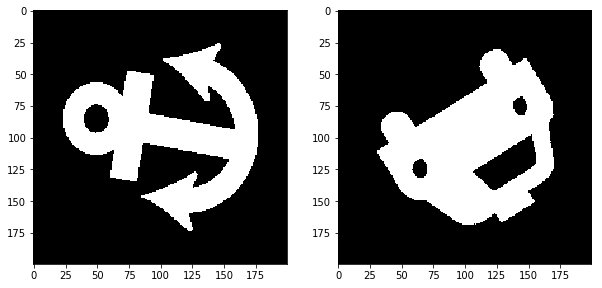

In [35]:
## added computation

def get_clean_sym(sym):
    gray = cv2.cvtColor(sym,cv2.COLOR_BGR2GRAY)
    res = gray.copy()
    res[gray < 240] = 0
    res[res > 0] = 1
    res = (res + 1) % 2
    return res



first_symbol = get_symbol(cards[0], 5)
second_symbol = get_symbol(cards[2], 4)

first_edged = get_clean_sym(cv2.resize(first_symbol, (200, 200), interpolation = cv2.INTER_AREA))
second_edged = get_clean_sym(cv2.resize(second_symbol, (200, 200), interpolation = cv2.INTER_AREA))


fig=plt.figure(figsize=(10, 15))
fig.add_subplot(1, 2, 1)
plt.imshow(first_edged, cmap = 'gray')
fig.add_subplot(1, 2, 2)
plt.imshow(second_edged, cmap = 'gray')
plt.show()

In [36]:
import imutils
from skimage import feature


dst1 = cv2.cornerHarris(first_edged.astype(np.uint8),2, 3, 0.04) 
dst2 = cv2.cornerHarris(second_edged.astype(np.uint8), 2, 3, 0.04)

first_edged[dst1>0.10*dst1.max()]=25
second_edged[dst2>0.10*dst2.max()]=25
unique1, counts1 = np.unique(first_edged, return_counts=True)
dic1 = dict(zip(unique1, counts1))

unique2, counts2 = np.unique(second_edged, return_counts=True)
dic2 = dict(zip(unique2, counts2))


s1 = dic1[25]
s2 = dic2[25]

print(s1, s2)
print(abs(s2 - s1)/max(s1, s2))

95 59
0.37894736842105264


In [37]:
def get_harrys_score(sym1, sym2):
    first_symbol = sym1
    second_symbol = sym2

    first_edged = get_clean_sym(cv2.resize(first_symbol, (200, 200), interpolation = cv2.INTER_AREA))
    second_edged = get_clean_sym(cv2.resize(second_symbol, (200, 200), interpolation = cv2.INTER_AREA))

    dst1 = cv2.cornerHarris(first_edged,2,3,0.04) 
    dst2 = cv2.cornerHarris(second_edged, 2, 3, 0.04)

    first_edged[dst1>0.20*dst1.max()]=25
    second_edged[dst2>0.20*dst2.max()]=25

    unique1, counts1 = np.unique(first_edged, return_counts=True)
    dic1 = dict(zip(unique1, counts1))

    unique2, counts2 = np.unique(second_edged, return_counts=True)
    dic2 = dict(zip(unique2, counts2))

    s1 = dic1[25]
    s2 = dic2[25]
    
    return abs(s2 - s1) / max(s1, s2)

## Compute score on few examples

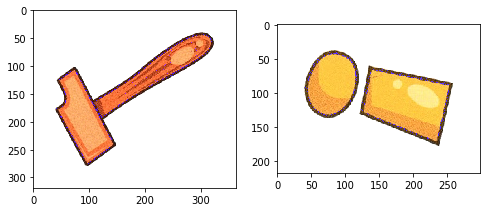

Score : 8


In [38]:
import random
i = random.randint(1, 8)
j = random.randint(1, 8)
k = random.randint(0, 10)
l = random.randint(0, 10)
first_symbol = get_symbol(cards[12],8)
second_symbol = get_symbol(cards[3],5)
fig=plt.figure(figsize=(8, 15))
fig.add_subplot(1, 2, 1)
plt.imshow(first_symbol, cmap = 'gray')
fig.add_subplot(1, 2, 2)
plt.imshow(second_symbol, cmap = 'gray')
plt.show()
print("Score : " + str(get_score(first_symbol,second_symbol)))

## Color test

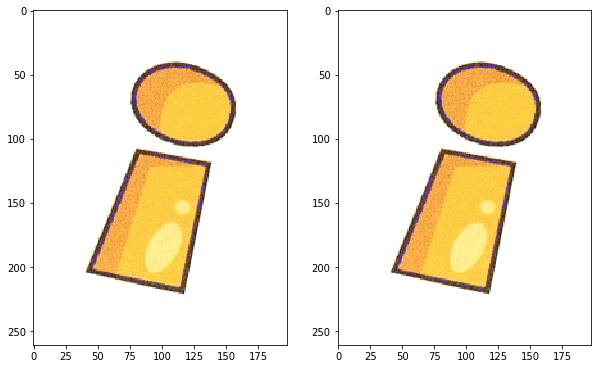

In [105]:
first_symbol = get_symbol(cards[1], 1)
second_symbol = get_symbol(cards[1], 1)
fig=plt.figure(figsize=(10, 15))
fig.add_subplot(1, 2, 1)
plt.imshow(first_symbol, cmap = 'gray')
fig.add_subplot(1, 2, 2)
plt.imshow(second_symbol, cmap = 'gray')
plt.show()

In [106]:
def color_test(symbol1, symbol2):
    
    hist1 = cv2.calcHist([symbol1], [0, 1, 2], None, [8, 8, 8],[0, 240, 0, 240, 0, 240])
    hist1 = cv2.normalize(hist1, hist1).flatten()
  
    hist2 = cv2.calcHist([symbol2], [0, 1, 2], None, [8, 8, 8],[0, 240, 0, 240, 0, 240])
    hist2 = cv2.normalize(hist2, hist2).flatten()
        
   
    
    d = cv2.compareHist(hist1, hist2, cv2.HISTCMP_CORREL)
    return d

In [107]:
color_test(first_symbol, second_symbol)

1.0

# Directories creation

In [52]:
def gen_dirs(img, Ids_Sym):
    out_masks = get_symbols(img)
    symbols = out_masks.copy()
    for i in range(8):
        symbol = get_symbol(img, i + 1)
        found = -1
        for id_sym in Ids_Sym:
            if(color_test(id_sym[1], symbol) > 0.85 and (get_score(id_sym[1], symbol) > 10)):
                found = id_sym[0]
                break
        if found == -1:
            os.mkdir("./Symbols/" + str(len(Ids_Sym) + 1))
            imageio.imsave("./Symbols/" + str(len(Ids_Sym) + 1) + "/1.png", symbol)
            Ids_Sym.append([len(Ids_Sym) + 1, symbol])
        else:
            id = len(os.listdir("./Symbols/" + str(found))) + 1
            imageio.imsave("./Symbols/" + str(found) + "/" + str(id) + ".png", symbol)

In [ ]:
Ids_Sym = []


for i in range(0):
    gen_dirs(cards[i], Ids_Sym)
    print("Dir created: " + str(i), )

# Masks Creation

In [112]:
import os

def gen_mask(img, arr_sym):
    out_masks = get_symbols(img)
    symbols = out_masks.copy()
    for i in range(8):
        symbol = get_symbol(img, i + 1)
        for j in range(len(arr_sym)):
            found = False
            if color_test(arr_sym[j][0], symbol) > 0.80:
                for sym in arr_sym[j]:
                    if color_test(sym, symbol) > 0.9999:
                        out_masks[symbols == i + 1] = j + 1
                        break
            if found:
                break
    return out_masks
            

In [113]:
#creation of an array of 57 containing all models loaded
arr_sym = [0] * 57


all_sym = sorted(os.listdir("./Symbols_Good"))


for dirs in all_sym:
    arr_sym[int(dirs) - 1] = np.array([np.array(imageio.imread(f)) for f in glob.glob("./Symbols_Good/" + dirs +"/*.png")])

In [151]:
#get list of mask


masks = []


for i in range(55):
    masks.append(gen_mask(cards[i], arr_sym))
    print("Mask created: " + str(i), np.unique(masks[i]))

Mask created: 0 [0 1 2 3 4 5 6 7 8]
Mask created: 1 [ 0  4  9 10 11 12 13 14 15]
Mask created: 2 [ 0  3 12 16 17 18 19 20 21]
Mask created: 3 [ 0  1  4  9 20 22 23 25 26]
Mask created: 4 [ 0  2 11 19 24 27 28 29 30]
Mask created: 5 [ 0  7 14 18 22 27 31 32 33]
Mask created: 6 [ 0  1 14 16 28 34 35 36 37]
Mask created: 7 [ 0  4 19 25 32 36 38 39 40]
Mask created: 8 [ 0  2  9 16 32 41 42 43 44]
Mask created: 9 [ 0  6 12 22 28 39 43 45 46]
Mask created: 10 [ 0  8 12 26 27 34 38 44 47]
Mask created: 11 [ 0  5 10 17 26 28 32 48 49]
Mask created: 12 [ 0  1 10 18 30 38 41 46 50]
Mask created: 13 [ 0  2 15 17 22 37 38 51 52]
Mask created: 14 [ 0  4 18 24 34 43 49 52 53]
Mask created: 15 [ 0  6  7 18 25 37 44 48 54]
Mask created: 16 [ 0  8 14 17 25 29 43 50 55]
Mask created: 17 [ 0  2  7 10 19 37 43 47 56]
Mask created: 18 [ 0  8  9 19 31 35 46 48 52]
Mask created: 19 [ 0  2 14 20 40 46 47 49 54]
Mask created: 20 [ 0  8 13 20 30 32 37 45 53]
Mask created: 21 [ 0  4 21 26 29 33 37 42 46]
Mask cr

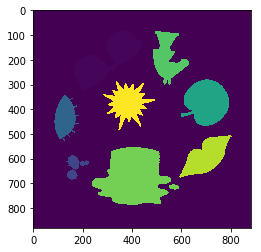

In [166]:
plt.imshow(masks[54])

In [175]:
# saving all the masks:



for i in range(len(masks)):
    id = i + 1
    if id < 10:
        id = '0' + str(id)
    imageio.imsave("./Masks/" + str(id) + ".tiff", masks[i].astype(np.uint8))





In [177]:
img =  np.array(imageio.imread("Masks/55.tiff"))

In [178]:
img.shape

(880, 880)

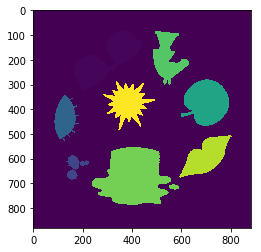

In [179]:
plt.imshow(img)

In [180]:
np.unique(img)

array([ 0,  1, 11, 17, 31, 39, 42, 47, 53], dtype=uint8)